In [1]:
using IL4model
using Plots
using LinearAlgebra
using Optim

Ls = LinRange(-14.0, -6.0, 50)

50-element LinRange{Float64}:
 -14.0,-13.8367,-13.6735,-13.5102,-13.3469,…,-6.4898,-6.32653,-6.16327,-6.0

In [2]:
# θ Kdα Kdβ Kdγ αT βT γT
ps = [1e8, 1e-9, 1e-9, 1e-6, 1000, 9000, 8000]

outtA = ligOutLs(Ls, ps)[:, 3];
pss = copy(ps)
pss[3] = 1.0
outtC = ligOutLs(Ls, pss)[:, 3];
# plot(Ls, outtA)
# plot!(Ls, outtC)

In [5]:
concs = LinRange(-12.6227, -6.60206, 11);
IL4sig = [0.124095, 0.5, 7.478, 38.125, 82.83, 93.29, 97.06, 94.75659333, 96.25678, 101.9945833, 101.74862];
neo4sig = [0.7, -0.4, -0.8, -0.98, -0.1, 1.32, 6.70, 14.03, 18.0, 23.041, 24.8];

# plot(concs, IL4sig)
# plot!(concs, neo4sig)

In [16]:
using StatsFuns

psInit = [1e8, 1e-9, 1e-9, 1e-6, 1000, 9000, 8000, 1e-9, 1e-9, 1e-6]

function diffcost(x)
    x = softplus.(x)
    outtA = ligOutLs(concs, x[1:7])[:, 3]
    x = copy(x)
    x[2:4] = x[8:10]
    outtC = ligOutLs(concs, x[1:7])[:, 3]

    return norm(outtA .- IL4sig) + norm(outtC .- neo4sig)
end

diffcost(invsoftplus.(psInit))

395.87411892191005

In [22]:
opts = Optim.Options(iterations = 200, store_trace = true, show_trace = false)

results = optimize(diffcost, invsoftplus.(psInit), LBFGS(), opts)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     5.582150e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.79e+01 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.79e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.76e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.21e-06 ≰ 0.0e+00
    |g(x)|                 = 1.02e+00 ≰ 1.0e-12

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    200
    f(x) calls:    638
    ∇f(x) calls:   638


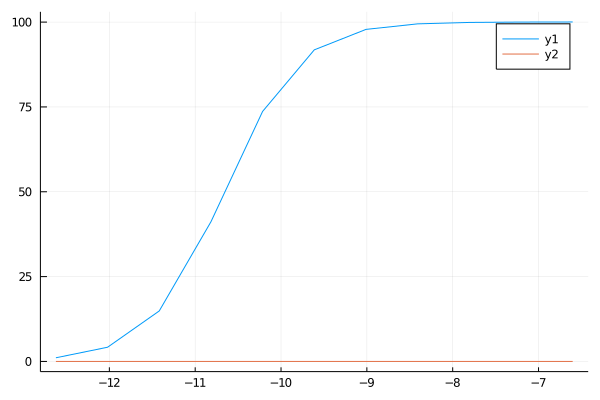

In [29]:
fitOut = softplus.(Optim.minimizer(results));

plot(concs, ligOutLs(concs, fitOut[1:7])[:, 3])
ff = copy(fitOut)
ff[2:4] = ff[8:10]
plot!(concs, ligOutLs(concs, ff)[:, 3])